#UniMiB_SHAR_ADL_load_dataset.ipynb. 
Loads the A-9 (ADL) portion of the UniMiB dataset from the Internet repository and converts the data into numpy arrays while adhering to the general format of the [Keras MNIST load_data function](https://keras.io/api/datasets/mnist/#load_data-function).

Arguments: tbd
Returns: Tuple of Numpy arrays:   
(x_train, y_train),(x_validation, y_validation)\[optional\],(x_test, y_test) 

* x_train\/validation\/test: containing float64 with shapes (num_samples, 151, {3,4,1})
* y_train\/validation\/test: containing int8 with shapes (num_samples 0-9)

The train/test split is by subject

Example usage:  
x_train, y_train, x_test, y_test = unimib_load_dataset()

Additional References  
 If you use the dataset and/or code, please cite this paper (downloadable from [here](http://www.mdpi.com/2076-3417/7/10/1101/html))

Developed and tested using colab.research.google.com  
To save as .py version use File > Download .py

Author:  Lee B. Hinkle, IMICS Lab, Texas State University, 2021

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.


TODOs:
* Fix document strings


In [1]:
import os
import shutil #https://docs.python.org/3/library/shutil.html
from shutil import unpack_archive # to unzip
#from shutil import make_archive # to create zip for storage
import requests #for downloading zip file
from scipy import io #for loadmat, matlab conversion
import pandas as pd
import numpy as np
#import matplotlib.pyplot as plt # for plotting - pandas uses matplotlib
from tabulate import tabulate # for verbose tables
from tensorflow.keras.utils import to_categorical # for one-hot encoding

2024-02-02 21:58:18.595864: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-02 21:58:18.595931: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-02 21:58:18.598383: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-02 21:58:18.608149: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-02 21:58:19.354272: W tensorflow/compiler/tf2

In [2]:
#credit https://stackoverflow.com/questions/9419162/download-returned-zip-file-from-url
#many other methods I tried failed to download the file properly
def download_url(url, save_path, chunk_size=128):
    r = requests.get(url, stream=True)
    with open(save_path, 'wb') as fd:
        for chunk in r.iter_content(chunk_size=chunk_size):
            fd.write(chunk)

In [3]:
def unimib_load_dataset(
    verbose = True,
    incl_xyz_accel = False, #include component accel_x/y/z in ____X data
    incl_rms_accel = True, #add rms value (total accel) of accel_x/y/z in ____X data
    incl_val_group = False, #True => returns x/y_test, x/y_validation, x/y_train
                           #False => combine test & validation groups
    split_subj = dict
                (train_subj = [4,5,6,7,8,10,11,12,14,15,19,20,21,22,24,26,27,29],
                validation_subj = [1,9,16,23,25,28],
                test_subj = [2,3,13,17,18,30]),
    one_hot_encode = True):
    #Download and unzip original dataset
    if (not os.path.isfile('./UniMiB-SHAR.zip')):
        print("Downloading UniMiB-SHAR.zip file")
        #invoking the shell command fails when exported to .py file
        #redirect link https://www.dropbox.com/s/raw/x2fpfqj0bpf8ep6/UniMiB-SHAR.zip
        #!wget https://www.dropbox.com/s/x2fpfqj0bpf8ep6/UniMiB-SHAR.zip
        download_url('https://www.dropbox.com/s/raw/x2fpfqj0bpf8ep6/UniMiB-SHAR.zip','./UniMiB-SHAR.zip')
    if (not os.path.isdir('./UniMiB-SHAR')):
        shutil.unpack_archive('./UniMiB-SHAR.zip','.','zip')
    #Convert .mat files to numpy ndarrays
    path_in = './UniMiB-SHAR/data'
    #loadmat loads matlab files as dictionary, keys: header, version, globals, data
    adl_data = io.loadmat(path_in + '/adl_data.mat')['adl_data']
    adl_names = io.loadmat(path_in + '/adl_names.mat', chars_as_strings=True)['adl_names']
    adl_labels = io.loadmat(path_in + '/adl_labels.mat')['adl_labels']

    if(verbose):
        headers = ("Raw data","shape", "object type", "data type")
        mydata = [("adl_data:", adl_data.shape, type(adl_data), adl_data.dtype),
                ("adl_labels:", adl_labels.shape ,type(adl_labels), adl_labels.dtype),
                ("adl_names:", adl_names.shape, type(adl_names), adl_names.dtype)]
        print(tabulate(mydata, headers=headers))
    #Reshape data and compute total (rms) acceleration
    num_samples = 151 
    #UniMiB SHAR has fixed size of 453 which is 151 accelX, 151 accely, 151 accelz
    adl_data = np.reshape(adl_data,(-1,num_samples,3), order='F') #uses Fortran order
    if (incl_rms_accel):
        rms_accel = np.sqrt((adl_data[:,:,0]**2) + (adl_data[:,:,1]**2) + (adl_data[:,:,2]**2))
        adl_data = np.dstack((adl_data,rms_accel))
    #remove component accel if needed
    if (not incl_xyz_accel):
        adl_data = np.delete(adl_data, [0,1,2], 2)
    if(verbose):
        headers = ("Reshaped data","shape", "object type", "data type")
        mydata = [("adl_data:", adl_data.shape, type(adl_data), adl_data.dtype),
                ("adl_labels:", adl_labels.shape ,type(adl_labels), adl_labels.dtype),
                ("adl_names:", adl_names.shape, type(adl_names), adl_names.dtype)]
        print(tabulate(mydata, headers=headers))
    #Split train/test sets, combine or make separate validation set
    #ref for this numpy gymnastics - find index of matching subject to sub_train/sub_test/sub_validate
    #https://numpy.org/doc/stable/reference/generated/numpy.isin.html


    act_num = (adl_labels[:,0])-1 #matlab source was 1 indexed, change to 0 indexed
    sub_num = (adl_labels[:,1]) #subject numbers are in column 1 of labels

    if (not incl_val_group):
        train_index = np.nonzero(np.isin(sub_num, split_subj['train_subj'] + 
                                        split_subj['validation_subj']))
        x_train = adl_data[train_index]
        y_train = act_num[train_index]
    else:
        train_index = np.nonzero(np.isin(sub_num, split_subj['train_subj']))
        x_train = adl_data[train_index]
        y_train = act_num[train_index]

        validation_index = np.nonzero(np.isin(sub_num, split_subj['validation_subj']))
        x_validation = adl_data[validation_index]
        y_validation = act_num[validation_index]

    test_index = np.nonzero(np.isin(sub_num, split_subj['test_subj']))
    x_test = adl_data[test_index]
    y_test = act_num[test_index]

    if (verbose):
        print("x/y_train shape ",x_train.shape,y_train.shape)
        if (incl_val_group):
            print("x/y_validation shape ",x_validation.shape,y_validation.shape)
        print("x/y_test shape  ",x_test.shape,y_test.shape)
    #If selected one-hot encode y_* using keras to_categorical, reference:
    #https://keras.io/api/utils/python_utils/#to_categorical-function and
    #https://machinelearningmastery.com/how-to-one-hot-encode-sequence-data-in-python/
    if (one_hot_encode):
        y_train = to_categorical(y_train, num_classes=9)
        if (incl_val_group):
            y_validation = to_categorical(y_validation, num_classes=9)
        y_test = to_categorical(y_test, num_classes=9)
        if (verbose):
            print("After one-hot encoding")
            print("x/y_train shape ",x_train.shape,y_train.shape)
            if (incl_val_group):
                print("x/y_validation shape ",x_validation.shape,y_validation.shape)
            print("x/y_test shape  ",x_test.shape,y_test.shape)
    if (incl_val_group):
        return x_train, y_train, x_validation, y_validation, x_test, y_test
    else:
        return x_train, y_train, x_test, y_test

In [4]:
if __name__ == "__main__":
    print("Downloading and processing UniMiB SHAR dataset, ADL Portion")
    x_train, y_train, x_validation, y_validation, x_test, y_test = unimib_load_dataset(incl_val_group=True)
    print("\nUniMiB SHAR returned arrays:")
    print("x_train shape ",x_train.shape," y_train shape ", y_train.shape)
    print("x_validation shape ",x_validation.shape," y_validation shape ", y_validation.shape)
    print("x_test shape  ",x_test.shape," y_test shape  ",y_test.shape)

Raw data     shape        object type              data type
-----------  -----------  -----------------------  -----------
adl_data:    (7579, 453)  <class 'numpy.ndarray'>  float64
adl_labels:  (7579, 3)    <class 'numpy.ndarray'>  uint8
adl_names:   (9, 1)       <class 'numpy.ndarray'>  object
Reshaped data    shape           object type              data type
---------------  --------------  -----------------------  -----------
adl_data:        (7579, 151, 1)  <class 'numpy.ndarray'>  float64
adl_labels:      (7579, 3)       <class 'numpy.ndarray'>  uint8
adl_names:       (9, 1)          <class 'numpy.ndarray'>  object
x/y_train shape  (4601, 151, 1) (4601,)
x/y_validation shape  (1454, 151, 1) (1454,)
x/y_test shape   (1524, 151, 1) (1524,)
After one-hot encoding
x/y_train shape  (4601, 151, 1) (4601, 9)
x/y_validation shape  (1454, 151, 1) (1454, 9)
x/y_test shape   (1524, 151, 1) (1524, 9)

UniMiB SHAR returned arrays:
x_train shape  (4601, 151, 1)  y_train shape  (4601, 9)
x_va

In [5]:
from tsai.models.utils import *
from tsai.basics import *
from tsai.inference import load_learner
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

In [30]:
def train_model(x_train, y_train):
    tfms = [None, TSClassification()]
    batch_tfms = TSStandardize(by_sample=True)
    mv_clf = TSClassifier(x_train, y_train, path='models', arch="LSTM_FCNPlus", tfms=tfms, batch_tfms=batch_tfms, metrics=accuracy, cbs=ShowGraph())
    mv_clf.fit_one_cycle(10, 1e-2)
    #mv_clf.export("mv_clf_cnn_test.pkl")
    return mv_clf

def run_model(x_test, mv_clf):
    #mv_clf = load_learner("models/mv_clf_cnn_test.pkl")
    probas, target, preds = mv_clf.get_X_preds(x_test, y_test)
    preds_labels = np.argmax(preds, axis=1)
    target_labels = np.argmax(target, axis=-1) # undo one-hot encoding
    return preds_labels, target_labels

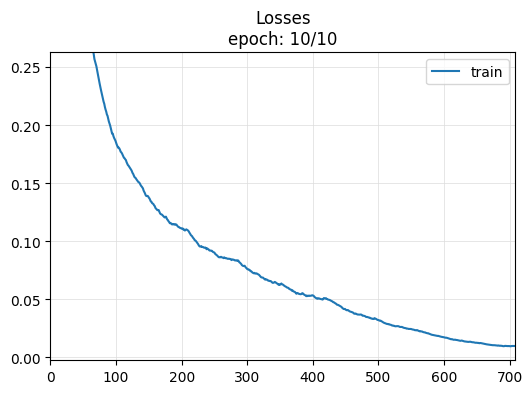

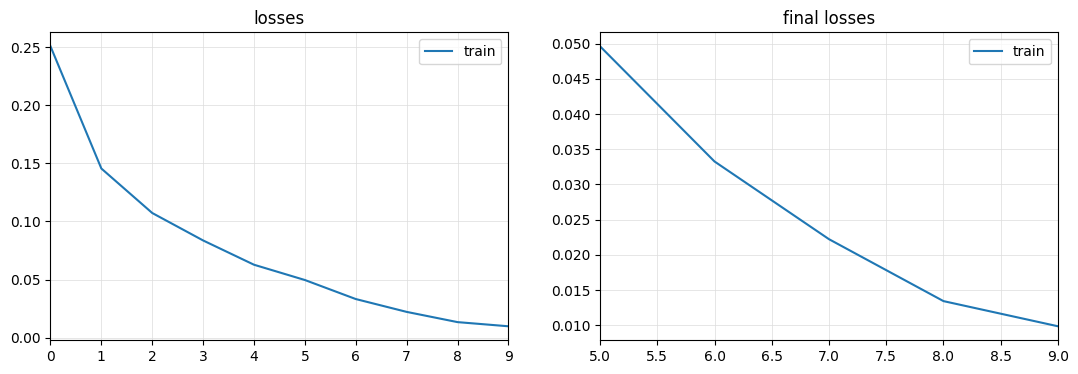

In [31]:
mv_clf = train_model(x_train, y_train)
preds_labels, target_labels = run_model(x_test, mv_clf)

In [32]:
print('Prediction accuracy: {0:.3f}'.format(accuracy_score(target_labels, preds_labels)))

Prediction accuracy: 0.883
